In [1]:
# project: p5
# submitter: hseverson4
# partner: none
# hours: 16

In [2]:
import edgar_utils as eu
import pandas as pd
from zipfile import ZipFile
from io import TextIOWrapper
import csv
from graphviz import Digraph
import geopandas as gpd
from shapely.geometry import box, Point

In [3]:
#Q1: what's the total size in bytes of the files requested?
with ZipFile('server_log.zip') as zf:
    with zf.open("rows.csv", "r") as f:
        tio = TextIOWrapper(f)
        dr=csv.DictReader(tio)
        list_of_dicts = list(dr)

df = pd.DataFrame(list_of_dicts)   
sizes = df['size'].squeeze().astype(float)
int(sizes.sum())

24801002666

In [4]:
#Q2: how many filings have been accessed by the top ten IPs?
df[['ip']].groupby('ip').size().sort_values(ascending=False)[:10].to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [5]:
#Q3: what fraction of the time do errors occur? #astype(float)
df2 = df[['code']].astype(float)>=400
len(df[df2.squeeze().tolist()]) / len(df)

0.03466852724527611

In [6]:
#Q4: what is the most frequently accessed file? 
def convert_cik(cik):
    return str(int(float(cik)))

df['cik'] = df['cik'].apply(convert_cik)
df['file'] = df['cik']+"/"+df['accession']+"/"+df["extention"]
df3 = df.groupby('file').size().sort_values(ascending=False)
file = pd.Series(df3.index.values, index=df3).iloc[0]
file

'1627631/0001627631-15-000004/.txt'

In [7]:
#Q5: how many requests were made by automated crawlers?
len(df[(df[['crawler']]=='1.0').squeeze().tolist()])

971

In [8]:
#Q6: which region uses EDGAR most heavily?
ips = df[['ip']].groupby('ip').size().sort_values(ascending=False)
top_ip = pd.Series(ips.index.values, index=ips).iloc[0]
eu.lookup_region(top_ip)

'United States of America'

In [9]:
#Q7: what fraction of IPs in each region are high-volume users?
regions_list = list(pd.Series(ips.index).apply(eu.lookup_region))
pct_high_vol = {}

ips_df = pd.DataFrame(ips)
ips_df['region'] = regions_list
high_vol_counts = ips_df[ips_df[0]>=1000].groupby('region').size()
all_counts = ips_df.groupby('region').size()
regions = list(all_counts.index)
high_vol_regions = set(high_vol_counts.index)
for reg in regions:
    if reg in high_vol_regions:
        pct_high_vol[reg] = high_vol_counts[reg] / all_counts[reg]
    else:
        pct_high_vol[reg] = 0/1
        
pct_high_vol = dict(sorted(pct_high_vol.items(), key=lambda item: item[1], reverse=True))
pct_high_vol

{'Bulgaria': 0.3333333333333333,
 'Ireland': 0.3125,
 'Korea (Republic of)': 0.2,
 'Australia': 0.07692307692307693,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'India': 0.058823529411764705,
 'United States of America': 0.019862490450725745,
 'Canada': 0.017857142857142856,
 'China': 0.006864988558352402,
 'France': 0.0036900369003690036,
 '-': 0.0,
 'Algeria': 0.0,
 'Angola': 0.0,
 'Armenia': 0.0,
 'Austria': 0.0,
 'Bangladesh': 0.0,
 'Brazil': 0.0,
 'Croatia': 0.0,
 'Cyprus': 0.0,
 'Czechia': 0.0,
 'Denmark': 0.0,
 'Egypt': 0.0,
 'Estonia': 0.0,
 'Finland': 0.0,
 'Germany': 0.0,
 'Greece': 0.0,
 'Honduras': 0.0,
 'Hong Kong': 0.0,
 'Hungary': 0.0,
 'Indonesia': 0.0,
 'Iraq': 0.0,
 'Israel': 0.0,
 'Italy': 0.0,
 'Japan': 0.0,
 'Jersey': 0.0,
 'Jordan': 0.0,
 'Latvia': 0.0,
 'Lebanon': 0.0,
 'Liberia': 0.0,
 'Luxembourg': 0.0,
 'Malaysia': 0.0,
 'Mexico': 0.0,
 'Mongolia': 0.0,
 'Morocco': 0.0,
 'Netherlands': 0.0,
 'Nigeria': 0.0,
 'North Macedonia'

In [10]:
#list(ips.index)
regions_list2 = list(map(eu.lookup_region, list(ips.index)))
regions_list2
#list(pd.Series(ips.index).apply(eu.lookup_region))

['United States of America',
 'China',
 'United States of America',
 'United States of America',
 'United States of America',
 'India',
 'United States of America',
 'United States of America',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Kingdom of Great Britain and Northern Ireland',
 'United States of America',
 'United States of America',
 'Korea (Republic of)',
 'United States of America',
 'China',
 'United States of America',
 'Canada',
 'United States of America',
 'United States of America',
 'Korea (Republic of)',
 'India',
 'United States of America',
 'France',
 'United States of America',
 'United States of America',
 'United States of America',
 'United States of America',
 'Bulgaria',
 'Ireland',
 'Ireland',
 'Ireland',
 'Ireland',
 'United States of America',
 'Australia',
 'United States of America',
 'United States of America',
 'United States of America',
 'China',
 'United States of America',
 'United States of America',
 'United Kingdom of Grea

In [11]:
#Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?
filing_objects = {}

with ZipFile('docs.zip') as zf:
    member_names = zf.namelist()
    names = member_names #was []
    #for nm in member_names:
    #    if "." in nm:
    #        names.append(nm)

    for name in names:
        with zf.open(name, "r") as f:
            tio_h = f.read()
            result_str = str(tio_h, encoding="utf-8")
            obj = eu.Filing(result_str)
            filing_objects[name] = obj
        
        
filing_objects["850693/0000850693-07-000159/-index.htm"].dates

['2007-07-25', '2007-07-25', '2007-07-23']

In [12]:
#Q9: what is the distribution of states for the filings in docs.zip?
states_dist = {}

for file in filing_objects:
    obj = filing_objects[file]
    state = obj.state()
    if state is not None:
        if state in states_dist:
            states_dist[state] += 1
        else:
            states_dist[state] = 1
        
list_of_tup = sorted(states_dist.items(), key=lambda x:x[1])
states_dist_sorted = {}
while len(list_of_tup) > 0:
    tup = list_of_tup.pop(-1)
    states_dist_sorted[tup[0]] = tup[1]
states_dist_sorted

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'PA': 25,
 'IL': 25,
 'CO': 25,
 'NJ': 23,
 'FL': 21,
 'MN': 15,
 'VA': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'DE': 10,
 'OH': 10,
 'WI': 9,
 'NC': 9,
 'GA': 8,
 'OK': 7,
 'IA': 6,
 'NV': 6,
 'OX': 6,
 'AZ': 5,
 'KS': 5,
 'UT': 5,
 'MO': 4,
 'TN': 4,
 'IN': 4,
 'WA': 3,
 'WV': 2,
 'OR': 2,
 'LA': 2,
 'NE': 2,
 'KY': 2,
 'ME': 1,
 'DC': 1,
 'ID': 1,
 'VT': 1,
 'AR': 1,
 'NM': 1,
 'SD': 1,
 'AL': 1,
 'MS': 1}

In [13]:
#Q10: what is the distribution of SIC codes for the filings in docs.zip?
sic_dict = {}

for file in filing_objects:
    obj = filing_objects[file]
    sic = obj.sic
    if sic is not None:
        if sic in sic_dict:
            sic_dict[sic] += 1
        else:
            sic_dict[sic] = 1
        
list_of_tup2 = sorted(sic_dict.items(), key=lambda x:x[1])
sic_dict_sorted = {}
while len(list_of_tup2) > 0:
    tup = list_of_tup2.pop(-1)
    sic_dict_sorted[tup[0]] = tup[1]
sic_dict_sorted

{2834: 40,
 6021: 20,
 6798: 20,
 1311: 20,
 6022: 20,
 1389: 19,
 6211: 17,
 6189: 17,
 2836: 13,
 6029: 11,
 7372: 11,
 1000: 11,
 7389: 11,
 6331: 10,
 6282: 8,
 2860: 8,
 4911: 8,
 6199: 8,
 7370: 7,
 7371: 6,
 3841: 6,
 3826: 5,
 900: 5,
 8742: 5,
 4522: 5,
 1700: 5,
 4931: 5,
 3674: 5,
 5812: 4,
 3663: 4,
 3842: 4,
 4813: 4,
 6035: 4,
 2510: 4,
 7374: 4,
 7373: 3,
 7200: 3,
 2800: 3,
 3576: 3,
 1400: 3,
 8062: 3,
 3510: 3,
 3420: 3,
 6799: 3,
 3829: 3,
 6221: 3,
 3620: 3,
 7830: 2,
 4512: 2,
 5661: 2,
 7900: 2,
 5065: 2,
 4812: 2,
 2870: 2,
 1531: 2,
 3825: 2,
 2111: 2,
 3690: 2,
 3559: 2,
 3695: 2,
 3272: 2,
 6141: 2,
 3577: 2,
 3661: 2,
 5122: 2,
 3621: 2,
 3679: 2,
 4922: 2,
 7812: 2,
 1382: 2,
 5172: 2,
 8711: 2,
 4841: 2,
 5500: 2,
 5900: 2,
 3669: 2,
 1221: 2,
 3845: 2,
 6321: 2,
 6324: 2,
 8082: 2,
 6311: 2,
 1731: 2,
 5940: 2,
 3990: 2,
 2810: 2,
 1040: 2,
 8731: 2,
 1623: 1,
 2273: 1,
 7990: 1,
 3443: 1,
 3827: 1,
 6792: 1,
 3678: 1,
 5945: 1,
 6111: 1,
 2430: 1,
 5531: 

In [14]:
#Q11: what is the distribution of requests across industries?
industry_req_dist = {}
for i in range(len(df)):
    combined = df.loc[i, 'file']
    if combined in filing_objects:
        obj = filing_objects[combined]
        sic = obj.sic
        if sic is not None:
            if sic in industry_req_dist:
                industry_req_dist[sic] += 1
            else:
                industry_req_dist[sic] = 1
            
industry_req_series = pd.Series(industry_req_dist).sort_values(ascending=False)
for k in industry_req_series:
    k = int(k)
industry_req_series.to_dict()

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 2510: 171,
 6282: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 5311: 90,
 6798: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 900: 39,
 7370: 39,
 3621: 38,
 6513: 38,
 5172: 36,
 4213: 35,
 5900: 35,
 3990: 34,
 5122: 34,
 2070: 33,
 5944: 33,
 8090: 32,
 1700: 31,
 4922: 31,
 3312: 31,
 1381: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 3663: 23,
 4955: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 6792: 19,
 5812: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 6035: 7,
 4833: 7,
 2430: 6,
 3571: 6,
 3674: 5,
 3679: 5,
 4813: 4,
 4812: 4,
 3678: 4,
 5500: 4,
 1531: 4,
 6411: 3,
 3576: 3,
 8062: 3,
 2800: 3,
 3420: 3,
 1400: 3,
 2111: 2,
 7900: 2,
 5661: 2,
 6141: 

In [15]:
#Q12: how many requests were made in each hour?
def get_hour(some_str):
    return int(some_str[:2])

tms = df['time'].apply(get_hour)
pd.DataFrame(tms).groupby(by = 'time').size().to_dict()

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['index'] = list(range(len(rows)))
/tmp/ipykernel_237519/200895922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

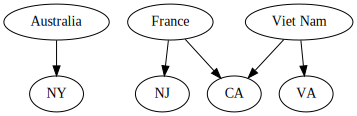

In [16]:
#Q13: what is the geographic overlap in interest between Australia, France, and Viet Nam?
q13_regions = ['Australia', 'France','Viet Nam']

def find_states(region):
    global ips_df
    global filing_objects
    states = set()
    ips = (ips_df[ips_df['region'] == region]).index 
    for ip in ips:
        rows = df[df['ip'] == ip]
        rows['index'] = list(range(len(rows)))
        rows = rows.set_index('index') # reset the df index here (to make looping over it easier), which causes a bunch of harmless warning messages
        if len(rows) > 0:
            for i in range(len(rows)):
                file = rows.loc[i, 'file']
                try:
                    state = filing_objects[file].state()
                    states.add(state)
                except KeyError:
                    continue
                    
    return states

q13_dict = {}
for region in q13_regions:
    q13_dict[region] = find_states(region)
    
g = Digraph()
for region in q13_dict:
    g.node(region)
    for state in q13_dict[region]:
        g.edge(region, state)
g

In [17]:
#Q14: what are the most commonly seen street addresses?
def get_address(file):
    global filing_objects
    if file in filing_objects:
        address = filing_objects[file].addresses
        return address
    else:
        return None

df_files = df['file']
addresses = df_files.apply(get_address)
df['address'] = addresses

def check_for_none(val):
    if val is None:
        return False
    return True

nones = df['address'].apply(check_for_none)

street_addresses = []
def process_address(addy_list):
    global street_addresses
    for address in addy_list:
        street_addresses.append(address)
        
df[nones]['address'].apply(process_address)
as_series = pd.DataFrame(street_addresses, columns=['address']).groupby('address').size().sort_values(ascending=False)
as_df = pd.DataFrame(as_series, columns=['count'])
addresses_225 = as_df[as_df['count'] >= 225].to_dict()['count']
addresses_225

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225}

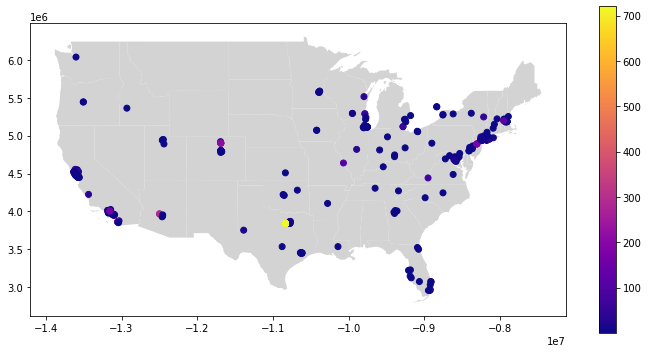

In [18]:
#Q15: geographic plotting of headquarters
df_gpd = gpd.read_file("locations.geojson")
df_gpd = df_gpd.set_index('address')
mainland_window = box(-130, 20, -55, 50)
df_gpd = gpd.GeoDataFrame(df_gpd.intersection(mainland_window))
df_gpd = df_gpd.rename(columns={0:'geometry'})
df_gpd = df_gpd.to_crs("epsg:3395")
df_gpd = df_gpd.join(as_df)

background = gpd.read_file("shapes/cb_2018_us_state_20m.shp")
back = background.intersection(mainland_window)
back = back.to_crs(df_gpd.crs)

ax = back.plot(color="lightgray", figsize=(12,6))
df_gpd.plot(column="count", legend=True, cmap="plasma", ax=ax)
None